# Moving a piano in a San Francisco Apartment

This example is heavily inspired from the one presented on [Dr James Sethian's
page](https://math.berkeley.edu/~sethian/2006/Applications/Robotics/robotics.html).

The objective of the problem proposed here is to determine a shortest path to
move an object in a constrained space without hitting the walls. When the
object shape is long (e.g. a piano) and the accessible space is very
constrained (e.g. an apartment with narrow doors and corridors), it will
become necessary to account for the orientation of the object. The problem is
therefore now posed in a 3-D $(x, y, θ)$ space, where $x$ and $y$ account for
the position of the center of the piano, and $θ$ its orientation.

Let's try and solve this with a 3-D Fast Sweeping solver.

We first load the required packages

In [1]:
import Pkg                             #hide
Pkg.activate(joinpath(@__DIR__, "..")) #hide
Pkg.instantiate()                      #hide

using Eikonal
using Plots

  Activating project at `~/projets/Eikonal.jl/docs`


The position of the walls is loaded from a PNG image.

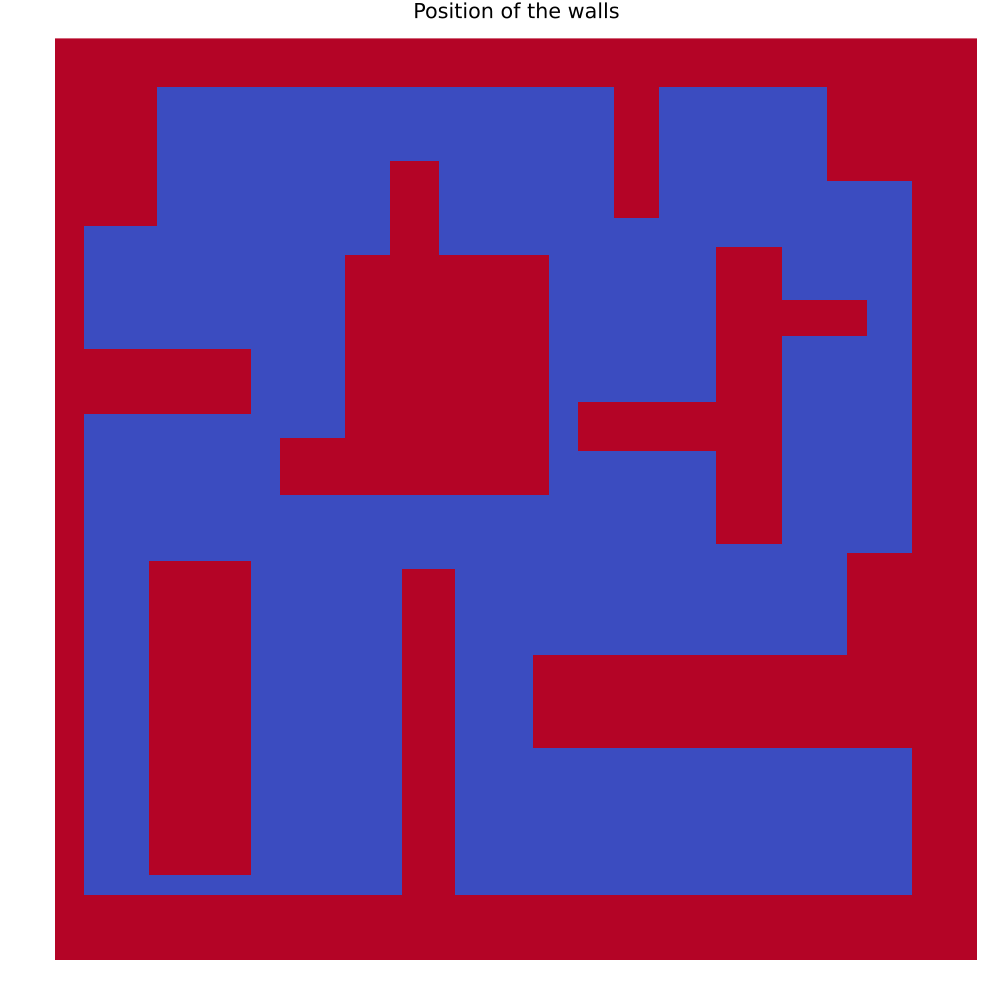

In [2]:
walls = Eikonal.from_png("piano.png", ["white"=>false, "black"=>true])
heatmap(walls, c=:coolwarm,
        title = "Position of the walls",
        aspect_ratio=1, size=(1000, 1000),
        showaxis=false, legend=false, grid=false)

We then define a discrete set of directions. *(Note that $θ=-π$ and $θ=π$ are
the same direction and should therefore be connected, but in this model we
consider them as entirely separate directions. This means that we won't be
able to find solutions in which the piano performs a complete 360° turn.)*

In [3]:
const θ = LinRange(-π, π, 101)

101-element LinRange{Float64, Int64}:
 -3.14159, -3.07876, -3.01593, -2.9531, …, 2.9531, 3.01593, 3.07876, 3.14159

Let's compute a 3-D slowness array indicating the set of valid positions and
orientations for the piano. A given position is invalid for a given
orientation if (and only if) some part of the piano touches the walls or falls
outside the domain. Such invalid positions and orientations are associated to
an infinite slowness. Conversely, valid positions and orientations are
associated to an (arbitrary) finite slowness.

In [4]:
const SIZE = (6, 40)

function slowness(walls, θ)
    σ = similar(walls, Float64, (axes(walls)..., axes(θ)...))
    (w, h) = (SIZE .÷ 2) .+ 1

    valid_indices = CartesianIndices(walls)
    for I in CartesianIndices(σ)
        i,j,k = Tuple(I)
        invalid = any(Iterators.product(-w:w, -h:h)) do (s1, s2)
            i′ = round(Int, i + s1*cos(θ[k]) - s2*sin(θ[k]))
            j′ = round(Int, j + s1*sin(θ[k]) + s2*cos(θ[k]))
            I′ = CartesianIndex(i′, j′)
            I′ ∈ valid_indices || return true
            return walls[I′]
        end
        σ[I] = invalid ? Inf : 1.0
    end

    σ
end

σ = slowness(walls, θ)
size(σ)

(226, 226, 101)

For example, let us represent the set of valid positions for the center of the
piano when $θ=0$:

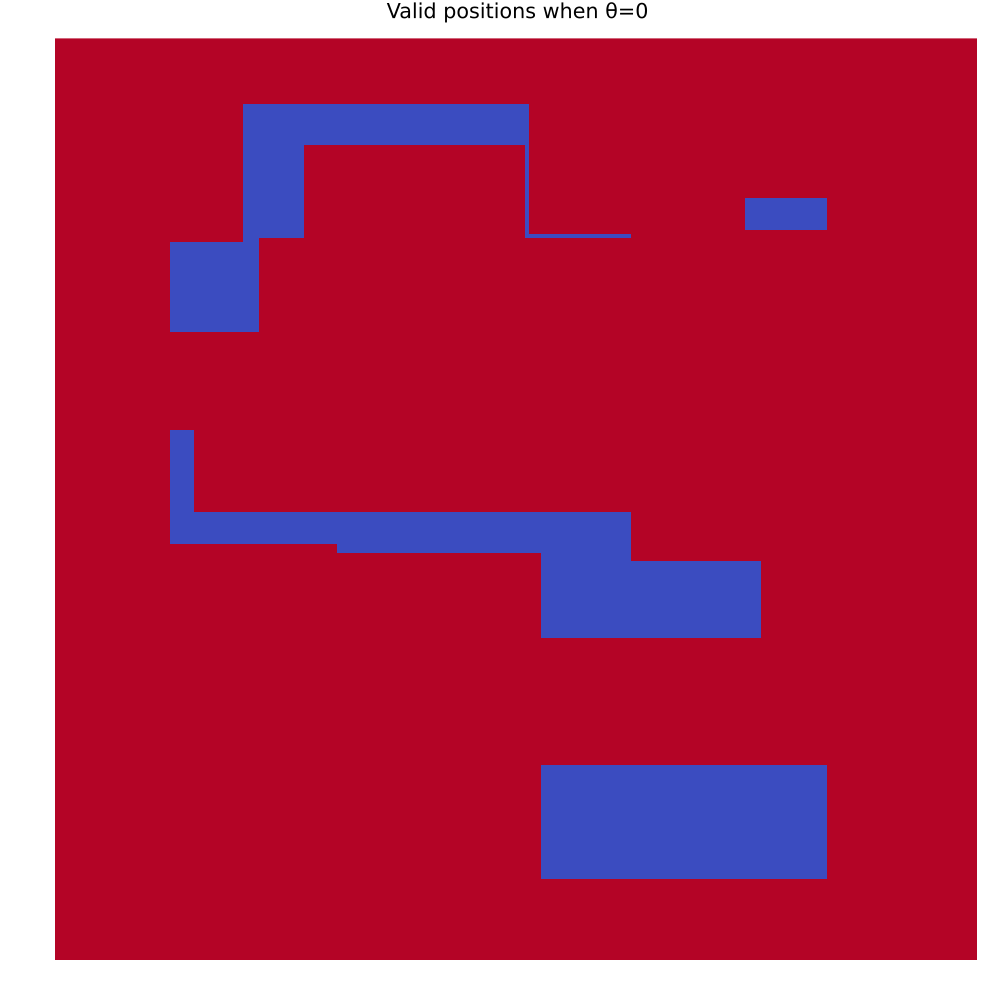

In [5]:
heatmap(min.(σ[:,:,51], 2.), c=:coolwarm,
        title = "Valid positions when θ=0",
        aspect_ratio=1, size=(1000, 1000),
        showaxis=false, legend=false, grid=false)

We can now create a Fast Sweeping solver for this problem:

In [6]:
sol = FastSweeping(σ)

FastSweeping solver on a 226×226×101 grid

Let's assume for example that the piano comes into the apartment via the front
door at the bottom right corner of the map (this is the origin of the path),
and needs to go to the back room at the top (this is our destination). In both
positions, the piano should be horizontal ($θ=0$):

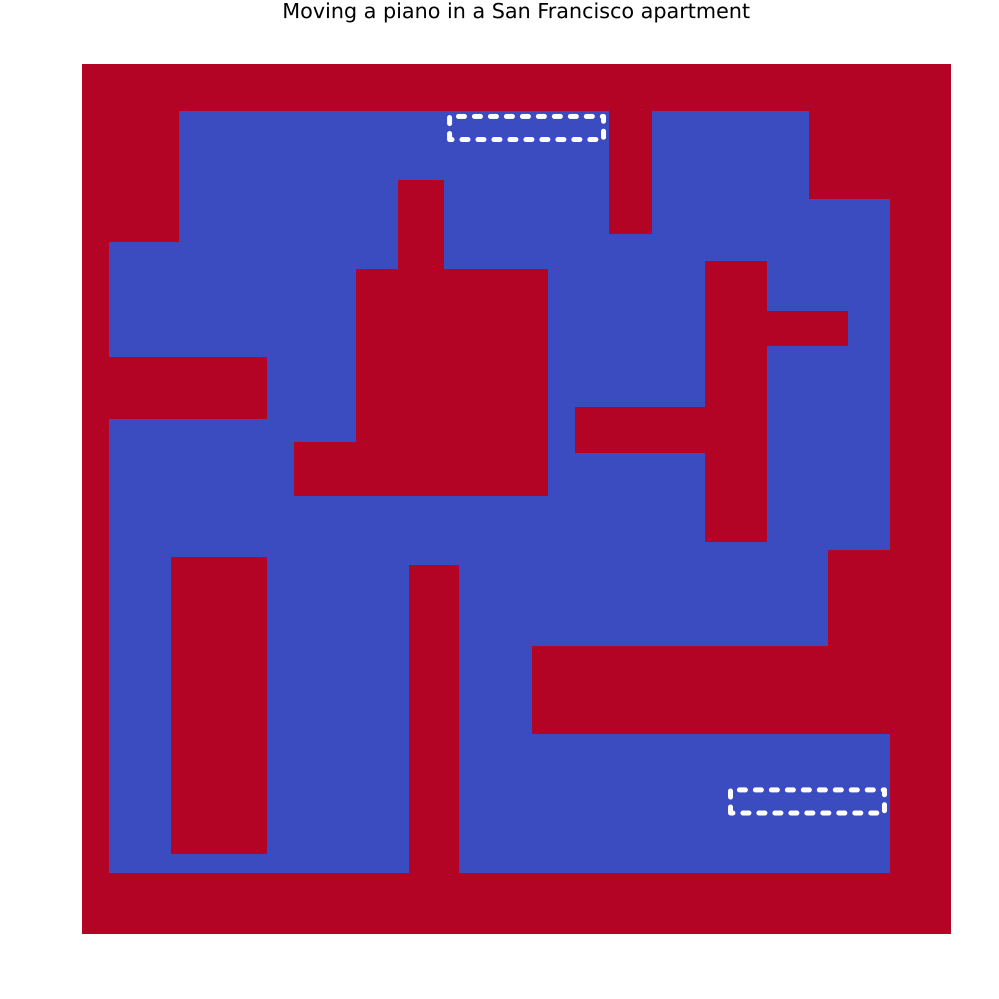

In [7]:
orig = (35,  189, 51)
dest = (210, 116, 51)

const LW = 4
const LC = :white

function piano_corners(pos)
    (w, h) = SIZE .÷ 2
    (i, j, k) = pos
    x = Float64[]; y = Float64[]
    for (s1, s2) in ((-1,-1), (-1,1), (1,1), (1, -1), (-1,-1))
        push!(x, i + s2*w*cos(θ[k]) - s1*h*sin(θ[k]))
        push!(y, j + s2*w*sin(θ[k]) + s1*h*cos(θ[k]))
    end
    (y, x)
end

function background()
    plot(title = "Moving a piano in a San Francisco apartment",
         aspect_ratio=1, size=(1000, 1000),
         showaxis=false, legend=false, grid=false)
    heatmap!(walls, c=:coolwarm)
    plot!(piano_corners(orig)..., label="", linecolor=LC, linestyle=:dot, linewidth=LW+1)
    plot!(piano_corners(dest)..., label="", linecolor=LC, linestyle=:dot, linewidth=LW+1)
end

background()

Let's run the solver, setting the source of the front at the origin. Hopefully
there exists a valid path, in which case we'll get a finite first arrival time
at the destination.

In [8]:
init!(sol, orig)
@time sweep!(sol, verbose=true, epsilon=1e-2)
@assert isfinite(sol.t[dest...])

iter 1, sweep 1: change = Inf
iter 1, sweep 2: change = Inf
iter 1, sweep 3: change = Inf
iter 1, sweep 4: change = Inf
iter 1, sweep 5: change = Inf
iter 1, sweep 6: change = Inf
iter 1, sweep 7: change = Inf
iter 1, sweep 8: change = Inf
iter 2, sweep 1: change = Inf
iter 2, sweep 2: change = Inf
iter 2, sweep 3: change = Inf
iter 2, sweep 4: change = Inf
iter 2, sweep 5: change = Inf
iter 2, sweep 6: change = Inf
iter 2, sweep 7: change = Inf
iter 2, sweep 8: change = Inf
iter 3, sweep 1: change = Inf
iter 3, sweep 2: change = Inf
iter 3, sweep 3: change = Inf
iter 3, sweep 4: change = Inf
iter 3, sweep 5: change = Inf
iter 3, sweep 6: change = Inf
iter 3, sweep 7: change = Inf
iter 3, sweep 8: change = Inf
iter 4, sweep 1: change = Inf
iter 4, sweep 2: change = Inf
iter 4, sweep 3: change = Inf
iter 4, sweep 4: change = Inf
iter 4, sweep 5: change = Inf
iter 4, sweep 6: change = Inf
iter 4, sweep 7: change = Inf
iter 4, sweep 8: change = Inf
iter 5, sweep 1: change = Inf
iter 5, sw

The path itself can be retrieved by back-propagation from the destination to
the origin:

In [9]:
r = ray(sol.t, dest, Eikonal.NearestMin()) |> reverse!

317-element Vector{Tuple{Int64, Int64, Int64}}:
 (35, 189, 51)
 (35, 188, 51)
 (35, 187, 51)
 (35, 186, 51)
 (35, 185, 51)
 (35, 184, 51)
 (35, 183, 51)
 (35, 182, 51)
 (35, 181, 51)
 (35, 180, 51)
 ⋮
 (204, 108, 50)
 (204, 109, 50)
 (204, 110, 50)
 (205, 111, 49)
 (206, 112, 49)
 (207, 113, 49)
 (208, 114, 50)
 (209, 115, 51)
 (210, 116, 51)

[ Info: Saved animation to /home/francois/projets/Eikonal.jl/docs/piano/piano_traj.gif


Plots.AnimatedGif("/home/francois/projets/Eikonal.jl/docs/piano/piano_traj.gif")
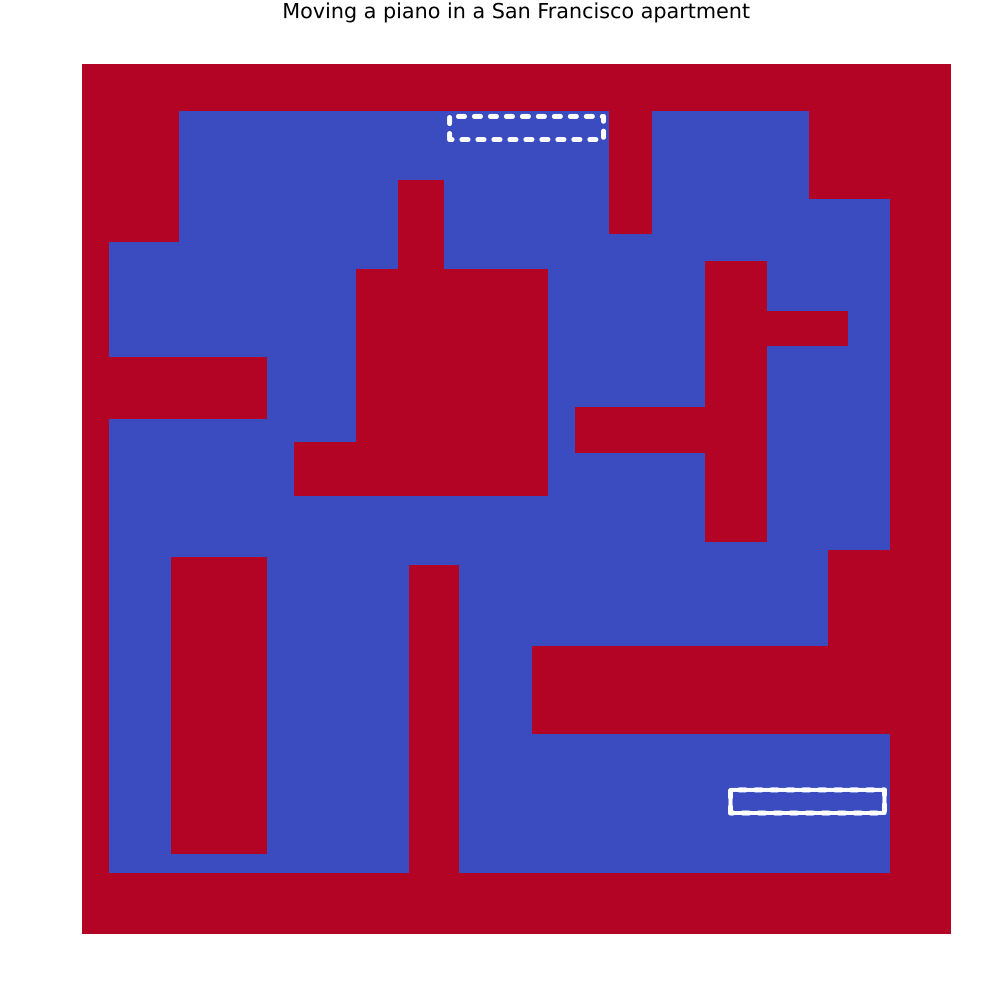

In [10]:
anim = @animate for pos in r
    plt = background()
    plot!(plt, piano_corners(pos)..., label="", linecolor=LC, linewidth=LW)
end
gif(anim, "piano_traj.gif", fps=15)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*